# Simultaneous least squares fit

## Formulas

### Damped harmonic oscillator
Differential equation:
$$m \ddot x = -k x - \alpha \dot x$$
After dividing by $m$ one obtains
$$\ddot x + 2 \beta \dot x + \omega_0^2 x = 0; \quad \beta = \frac{\alpha}{2m}$$
In case of undercritical damping ($\beta < \omega_0$) the solution is :
$$x(t) = x_0 e^{- \beta t} \cos(\omega t + \varphi_0); \quad \omega = \sqrt{\omega_0^2 - \beta^2}$$
 
### Driven harmonic oscillator
Differential equation:
$$\ddot x + 2 \beta \dot x + \omega_0^2 x = K \cos \omega t; \quad K = \frac{f}{m}$$

Ansatz:
$$x(t) = A \cos (\omega t + \varphi) $$

Solution
$$A(\omega) = \frac{f/m}{\sqrt{(\omega^2 - \omega_0^2)^2 + 4 \beta^2 \omega^2}}$$

Phase shift between driving force and oscillator:
$$\tan \varphi = \frac{2 \beta \omega}{\omega^2 - \omega_0^2}, \quad -\pi \le \varphi \le 0$$

## Tasks

a) Fit the $x(t)$, $A(\omega)$ individually using the method of least squares

b) Fit $x(t)$ and $A(\omega)$ simultaneously. More generally, what is the reasoning behind such a combined fit?

Use the data generation provided in `S01_least_squares_02_generate_data.ipynb` and read it in as sketched below.

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


In [151]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

## Read data

In [152]:
t_data, x_data, sigma_x = np.loadtxt('damped_free_oscillator.csv', delimiter=',', unpack=True)
omega_data, A_data, sigma_A, ph_data, sigma_ph = np.loadtxt('driven_oscillator.csv', 
                                                            delimiter=',', unpack=True)

## Solution

#### Part I: Damped harmonic oscillator

x0 = 0.09788329632475022 ± 0.0029562178850266775
b = 0.2820704937157194 ± 0.01347323122675584
w0 = 4.026954574444074 ± 0.014434430603873656
u0 = -0.03346074928319809 ± 0.03433104449175837
p= 0.9656567456235212
chi^2= 30.154262355315936
chi_red^2= 0.014250596576236264


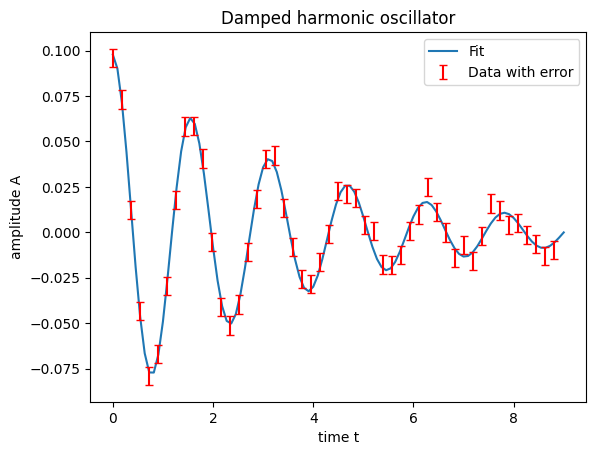

In [153]:
def harmo1(t, x0, b, w0, u0):
    return x0*np.exp(-b*t)*np.cos(np.sqrt(w0**2-b**2)*t+u0)

def chi2(x0, b, w0, u0):
    modell=harmo1(t_data, x0, b, w0, u0)
    chi2_value=np.sum(((x_data - modell) / sigma_x) ** 2)
    return chi2_value

# nummeric approxiamation for the chi^2-minimal solution using iminuit
m=Minuit(chi2, x0=0.1, b=0.3, w0=4, u0=0)
chi2.errordef = Minuit.LEAST_SQUARES
m.migrad()

print(f"x0 = {m.values['x0']} ± {m.errors['x0']}")
print(f"b = {m.values['b']} ± {m.errors['b']}")
print(f"w0 = {m.values['w0']} ± {m.errors['w0']}")
print(f"u0 = {m.values['u0']} ± {m.errors['u0']}")

x0=m.values['x0']
b=m.values['b']
w0=m.values['w0']
u0=m.values['u0']

# chi-value
from scipy.stats import chi2
x_fit=harmo1(t_data, x0, b, w0, u0)
chi_squard=np.sum((x_data-x_fit)**2/sigma_x**2)
dof = len(x_data) - 4
p = 1 - chi2.cdf(chi_squard, dof)
print('p=', p)
print('chi^2=', chi_squard)

# reduced chi value
chi_red=chi_squard/dof**2
print('chi_red^2=', chi_red)

t_range=np.linspace(0, 9, 100)
plt.plot(t_range, harmo1(t_range, x0, b, w0, u0), label='Fit')
plt.errorbar(t_data,x_data, yerr=sigma_x, fmt='None', ecolor='r', capsize=3, marker='s', mec='black', mfc='black', ms='2', label='Data with error')
plt.xlabel('time t')
plt.ylabel('amplitude A')
plt.title('Damped harmonic oscillator')
plt.legend()

#### Part II: Driven harmonic oscillator

##### a) Fit the $x(t)$, $A(\omega)$ individually using the method of least squares

w0 = 4.008915977733426 ± 0.09518430907994789
b = 0.2765125253944284 ± 0.07130484823345644


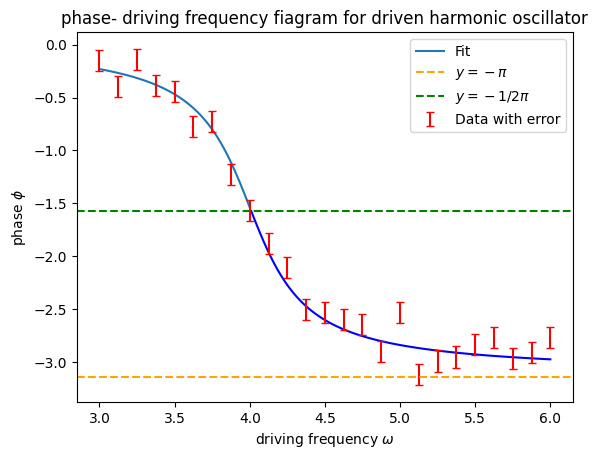

In [154]:
# Fit tan(u)=2bw/(w^2-w0^2)
def phase1(w, w0, b):
    return np.arctan((2*b*w)/(w**2-w0**2))

def chi2_1(w0, b):                                                             # Fit 1. Part
    modell1=phase1(omega_data[0:7], w0, b)
    chi2_value=np.sum(((ph_data[0:7] - modell1) / sigma_ph[0:7]) ** 2)
    return chi2_value

m1=Minuit(chi2_1, w0=4, b=0.3)
chi2_1.errordef = Minuit.LEAST_SQUARES
m1.migrad()
print(f"w0 = {m1.values['w0']} ± {m1.errors['w0']}")
print(f"b = {m1.values['b']} ± {m1.errors['b']}")

w0=m1.values['w0']
b=m1.values['b']

w_range1=np.linspace(3, 4, 100)
plt.plot(w_range1, phase1(w_range1, w0, b), label='Fit')

# 2.part use parameter generated by 1. part
def phase2(w, w0, b):
    return phase1(w, w0, b)-np.pi           # phase um \pi verschoben sonst Sprung

w_range2=np.linspace(4.01, 6, 100)
plt.plot(w_range2, phase2(w_range2, w0, b), color='blue')

plt.errorbar(omega_data,ph_data, yerr=sigma_ph, fmt='None', ecolor='r', capsize=3, marker='s', mec='black', mfc='black', ms='2', label='Data with error')
plt.axhline(-1*np.pi, color='orange', linestyle='--', label='$y=-\\pi$')
plt.axhline(-0.5*np.pi, color='green', linestyle='--', label='$y=-1/2\\pi$')
plt.xlabel('driving frequency $\\omega$')
plt.ylabel('phase $\\phi$')
plt.title('phase- driving frequency fiagram for driven harmonic oscillator')
plt.legend()

We have observed that, in the resonance case, when the driving frequency equals the natural frequency $\omega_0$, the phase takes the value $-\pi/2$ and asymptotically approaches $-\pi$. Due to the singularity at the resonance ($\omega=\omega_0$) in Data we must fit separatly, once below $\omega=4$ and once above it.

w0 = 4.000172311616449 ± 0.00922222814633746
b = 0.3010978954261978 ± 0.011549490449545122
K = 0.19924919914423328 ± 0.005033722936566169
p= 0.04582693805197424
chi^2= 34.29557919406343
chi_red^2= 0.07085863469847815


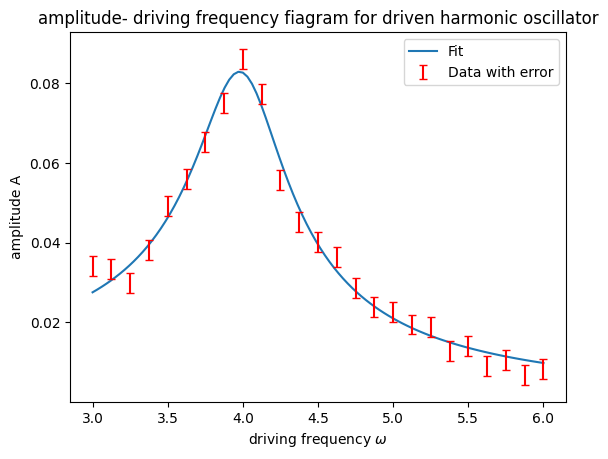

In [155]:
# Fit A(w)=K/(\sqrt{(w^2-w0^2)^2+4b^2w^2})
def amplitude(w, K, w0, b):
    return K/(np.sqrt((w**2-w0**2)**2+4*b**2*w**2))

def chi2_2(K, w0, b):
    modell2=amplitude(omega_data, K, w0, b)
    chi2_value=np.sum(((A_data - modell2) / sigma_A) ** 2)
    return chi2_value

m2=Minuit(chi2_2, K=0.2, w0=4, b=0.3)
chi2_2.errordef = Minuit.LEAST_SQUARES
m2.migrad()

print(f"w0 = {m2.values['w0']} ± {m2.errors['w0']}")
print(f"b = {m2.values['b']} ± {m2.errors['b']}")
print(f"K = {m2.values['K']} ± {m2.errors['K']}")

w0=m2.values['w0']
b=m2.values['b']
K=m2.values['K']

# chi-value
A_fit=amplitude(omega_data, K, w0, b)
chi_squard=np.sum((A_data-A_fit)**2/sigma_A**2)
dof = len(A_data) - 3
p = 1 - chi2.cdf(chi_squard, dof)
print('p=', p)
print('chi^2=', chi_squard)

# reduced chi value
chi_red=chi_squard/dof**2
print('chi_red^2=', chi_red)

w_range=np.linspace(3, 6, 100)
plt.plot(w_range, amplitude(w_range, K, w0, b), label='Fit')
plt.errorbar(omega_data,A_data, yerr=sigma_A, fmt='None', ecolor='r', capsize=3, marker='s', mec='black', mfc='black', ms='2', label='Data with error')
plt.xlabel('driving frequency $\\omega$')
plt.ylabel('amplitude A')
plt.title('amplitude- driving frequency fiagram for driven harmonic oscillator')
plt.legend()

Text(0, 0.5, 'amplitude A')

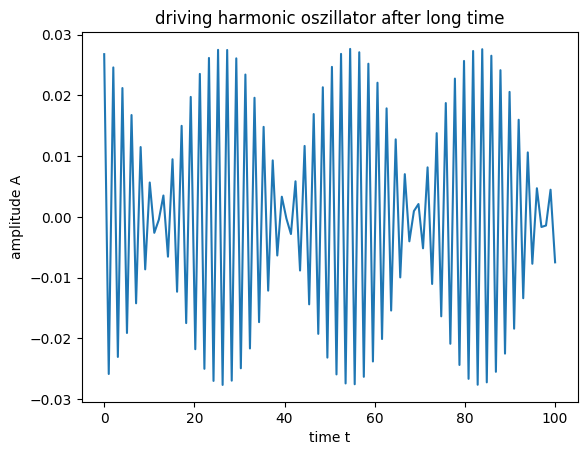

In [158]:
# Fit von x: Anregung nach langer Zeit
def ort(t, w, w0, b):
    K=0.2
    A=amplitude(w, K, w0, b)
    u=phase1(w, w0, b)
    return A*np.cos(w*t+u)

w=3
w0=4
b=0.3
t_range=np.linspace(0,100,100)
plt.plot(t_range, ort(t_range, w, w0, b), label='amplitude in time')
plt.title('driving harmonic oszillator after long time')
plt.xlabel('time t')
plt.ylabel('amplitude A')

##### b) Fit $x(t)$ and $A(\omega)$ simultaneously.

In [163]:
def chi2_total(x0, K, w0, b, u0):                           # minimize the total chi^2
    chi2_x = np.sum(((x_data - harmo1(t_data, x0, b, w0, u0)) / sigma_x) ** 2)
    chi2_A = np.sum(((A_data - amplitude(omega_data, K, w0, b)) / sigma_A) ** 2)
    return chi2_x + chi2_A

m_total = Minuit(chi2_total, x0=0.01, K=0.2, w0=4, b=0.3, u0=0)
chi2_total.errordef = Minuit.LEAST_SQUARES
m_total.migrad()

print(f"x0 = {m_total.values['x0']} ± {m_total.errors['x0']}")
print(f"K = {m_total.values['K']} ± {m_total.errors['K']}")
print(f"w0 = {m_total.values['w0']} ± {m_total.errors['w0']}")
print(f"b = {m_total.values['b']} ± {m_total.errors['b']}")
print(f"u0 = {m_total.values['u0']} ± {m_total.errors['u0']}")


x0 = 0.09978652724188752 ± 0.0025254916261066547
K = 0.19682710582366555 ± 0.004110870806852685
w0 = 4.007310467201546 ± 0.007722899228603449
b = 0.29408366970917094 ± 0.008707245758590549
u0 = 0.0026280778614797998 ± 0.026668591134938562


compared to the values we got before: $x_0=0.098$, $b=0.28$, $w_0=4$, $u_0=-0.03$ for damped harmonic oszillator, and $w_0=4$, $b=0.3$, $K=0.2$ for driving harmonic oszillator. Fitting $x(t)$ and $A(\omega)$ individually gives parameter estimates, but each fit is independent.  A combined fit considers both datasets simultaneously, allowing for more accurate and consistent parameter estimates, especially for shared parameters like $\omega_0$ and $\beta$.